In [6]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('confirm_drop0.csv', 
    dtype={'id':int, 'Date':object, 'inc':int}, 
    parse_dates=['Date'], 
    infer_datetime_format=True)
def MAE(freq, est_freq):
    return (abs(freq - est_freq)).mean()
def MRE(freq, est_freq):
    return (abs(np.dot(freq, np.arange(d)) - np.dot(est_freq, np.arange(d))))/(np.dot(freq, np.arange(d)) + np.finfo(np.float32).eps)
def jaccard_index(freq, est_freq, k):
    top_k = np.argpartition(-freq, k)[:k]
    est_top_k = np.argpartition(-est_freq, k)[:k]
    return len(np.intersect1d(top_k, est_top_k))/len(np.union1d(top_k, est_top_k))
def MSE(freq, est_freq):
    return (np.square(freq - est_freq)).mean()
def RMSE(freq, est_freq):
    return np.sqrt((np.square(freq - est_freq)).mean())

import numpy as np
from math import exp

from tqdm import trange

n = 3336
episode = 87
d = 100
universe = np.arange(d)

p_mat = np.zeros((d, d))
for i in range(d):
    p_mat[i] = np.abs(universe[i] - universe)*100

w = 30
epsilon = 1
epsilon_range = np.arange(0.1, 1.1, 0.1)
w_range = np.arange(5, 85, 5)
interval = pd.Timedelta('7d')
start_time = pd.Timestamp('2020-01-23')

In [4]:
current_time = start_time

uniform_util = []
for t in range(episode):
    data = df.loc[df['Date']==current_time]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.inc_id] += 1
        # randomization
        release_budget = epsilon/w
        exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
        exp_prob /= exp_prob.sum()
        private_inc = np.random.choice(universe, p=exp_prob)
        private_freq[private_inc] += 1
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    uniform_util.append(RMSE(true_freq, private_freq))
print(uniform_util)

[0.1414213562373095, 0.0, 0.4472135954999579, 2.630589287593181, 6.822023160324216, 16.1245154965971, 18.570945048650593, 21.177346387118476, 18.51431878303925, 15.505482901219168, 20.36663938896155, 17.265572680916208, 16.229602582934678, 14.974645237867907, 18.659046063504963, 19.01104941869333, 17.051686133634995, 18.018878988438765, 19.604081207748553, 18.879088961070128, 21.12297327555948, 19.342698880973153, 15.712415473121885, 16.192590898309017, 19.23122460999299, 21.26687565205571, 16.14930339054908, 20.750421682462264, 20.737405816543205, 19.183326093250876, 20.159365069366643, 17.01528724412256, 17.27888885316414, 16.32421514192949, 17.451074465487793, 10.370149468546728, 12.088837826689545, 7.797435475847171, 6.779380502671317, 6.830812543175226, 4.61519230368573, 6.962758074211684, 5.10098029794274, 7.140028011149536, 9.198912979260104, 7.049822692805827, 5.890670590009257, 7.158212067269313, 7.541883053985921, 10.961751684835777, 11.33931214845063, 11.680753400359071, 21.

In [5]:
window = np.zeros((n, episode), dtype=float)
# historical data
storage = [[] for _ in range(n)]

current_time = start_time
ratio = np.full(n, 0.45)
data_flag = np.zeros((n, episode), dtype=int)
release_flag = np.zeros((n, episode), dtype=int)
pid_error = np.zeros((n, episode), dtype=float)

ada_util = []
for t in range(episode):
    data = df.loc[df['Date']==current_time]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.inc_id] += 1
        data_flag[row.inc_id][t] = 1
        # release_flag = np.random.binomial(1, ratio)
        release_budget = epsilon/(w*ratio[row.id])
        remain = epsilon - window[row.id][max(0, t-w+1):t].sum()
        if (remain < release_budget): # or (release_flag == False):
            release_budget = 0
        if release_budget > 0:
            # randomization
            exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
            exp_prob /= exp_prob.sum()
            private_inc = np.random.choice(universe, p=exp_prob)
            # update window
            window[row.id][t] = release_budget
            storage[row.id].append(private_inc)
            release_flag[row.inc_id][t] = 1
        else:
            private_inc = storage[row.id][len(storage[row.id])-1]
        private_freq[private_inc] += 1
    if t > w:
        data_num = data_flag[:, max(0, t-w+1):t].sum(axis=1)
        # release_num = release_flag[:, max(0, t-w+1):t].sum(axis=1)
        release_num = release_flag[:, 0:t].sum(axis=1)
        pid_error[:, t] = abs(release_num/t - data_num/min(w, t))
        # pid_error[:, t] = abs(data_num/w - ratio) 
        error = np.sign(pid_error[:, t])*(0.1*pid_error[:, t] + 0.0*pid_error[:, max(0, t-w+1):t].sum(axis=1)/min(w, t) + 0.0*(pid_error[:, t] - pid_error[:, t-1])) 
        ratio = np.clip(ratio + error, 1/w, 1) 
        # ratio = np.clip(data_num/w, 1/w, 1) 
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    ada_util.append(RMSE(true_freq, private_freq))
print(ada_util)

[0.0, 0.0, 0.0, 0.1414213562373095, 0.8717797887081347, 2.4289915602982237, 3.3136083051561784, 3.283291031876401, 2.209072203437452, 2.7712812921102037, 3.1654383582688825, 2.874021572639983, 2.891366458960192, 2.5059928172283334, 1.2884098726725126, 1.7146428199482247, 2.0591260281974, 3.4292856398964493, 3.671511950137164, 5.217278984298233, 6.456004956627589, 8.831760866327848, 11.998333217576516, 12.542726976220123, 9.631199302267605, 7.008566187174092, 6.243396511515186, 8.656789243131659, 8.402380615040002, 6.381222453417527, 7.274613391789285, 9.780593029055037, 12.99384469662463, 25.161478493920026, 26.833561075638098, 23.761733943464648, 20.414210736641277, 22.70990973121646, 24.250360822057885, 25.151938295089703, 9.99499874937461, 14.390274493559879, 11.971633138381748, 8.274055837375041, 5.344155686354955, 4.125530268947253, 4.993996395673509, 10.506188652408635, 12.268659258452, 14.935193336545732, 14.927826365549674, 15.278743403827423, 17.88463027294666, 11.303981599418

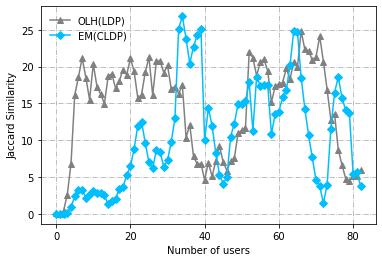

In [16]:
x = np.arange(len(uniform_util))
plt.plot(x, uniform_util, '^-', label='OLH(LDP)', color='grey')
plt.plot(x, ada_util, 'D-', label='EM(CLDP)', color='deepskyblue')
# plt.xticks(x)
plt.xlabel('Number of users')
plt.ylabel('Jaccard Similarity')
plt.legend(frameon=False)
plt.grid(linestyle='-.')
plt.savefig('user_num.pdf')
plt.show()